![Py4Eng](img/logo.png)

# Statistics
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import scipy.special as spec
import urllib.request
import os.path
import zipfile
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
np.random.seed(847)

Some of the presented exercises follow the book [IPython Cookbook](http://ipython-books.github.io/cookbook/) by [Cyrille Rossant](http://cyrille.rossant.net/).

# One sample mean hypothesis tests

Let's write a function that flips a coin `n` times and returns the number of times it landed on *head*. It's a special coin - the probability that it falls on *head* is `q`:

In [2]:
def flip(n, q):
    randoms = np.random.random(n)
    heads = randoms < q
    return heads.sum()

In [3]:
n = 100
q0 = 0.5
q = 0.54
x = flip(n, q=q)
x

61

Say we don't know what `q` is and we want to check if the coin is fair - that is, if `q` is 0.5. We can use a *hypothesis test* for this purpose. 

Our *null hypothesis* is $H_0: q=0.5$, whereas our alternative hypothesis is $H_A: q \ne 0.5$.

So we create a binomial random variable according to our null hypothesis, and we calculate the probability to get the result `x` or anything more extreme from this random variable using the probability mass function of `H0`. 

0.035200200217704376


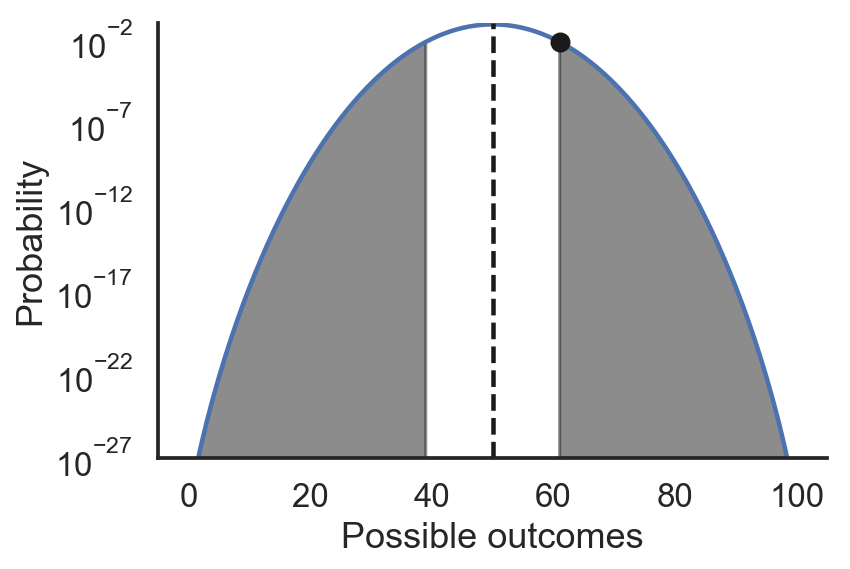

In [4]:
H0 = scipy.stats.binom(n, q0) # random variable of the null hypothesis
k = np.arange(0, n+1) # numbers from 0 to n

# plot probability of each result if null hypothesis is true
plt.plot(k, H0.pmf(k)) 
# plot probability of observation if null hypothesis is true
plt.plot(x, H0.pmf(x), 'ok') 
# plot highest probability of null hypothesis
plt.axvline(n*q0, ls='--', color='k')
# fill area of results as or less likely then observation
plt.fill_between(k[k>=x], H0.pmf(k[k>=x]), color='k', alpha=0.5)
plt.fill_between(k[k<=n*q0-(x-n*q0)], H0.pmf(k[k<=n*q0-(x-n*q0)]), color='k', alpha=0.5)

plt.ylim(1e-27, 1e-1)
plt.yscale('log')
plt.xlabel('Possible outcomes')
plt.ylabel('Probability')
sns.despine()

# probability of results as or less likely then observation
low_tail = H0.pmf(k[k<=n*q0-(x-n*q0)]) 
high_tail = H0.pmf(k[k>=x])
# sum of these results is the p-value
# p-value = probability to get this observation or worse if null hypothesis is true
pvalue = low_tail.sum() + high_tail.sum()
print(pvalue)

Therefore, the probability to get this result given that the null hypothesis is right is less than 1% and we tend to reject the null hypothesis. 

This "probability to get data given the model H0" is called the "**likelihood** of $H_0$ given the data". 
Specifcially, the likelihood H0 given the data is called **P-value**.

Let's run many experiments and compare their distribution to the $H_0$ distribution:

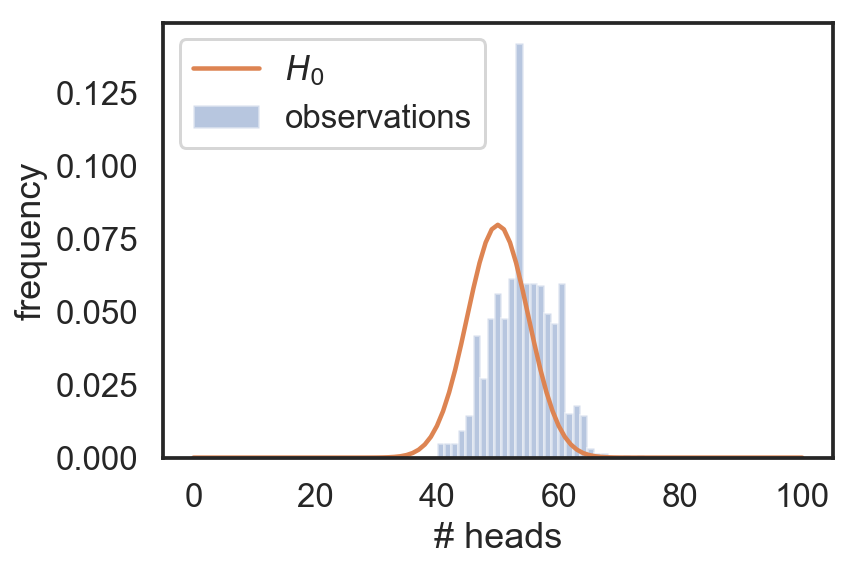

In [5]:
reps = 1000
nrange = range(0, n+1)
H0_pmf = H0.pmf(nrange)
xs = [flip(n, q) for _ in range(reps)]
sns.distplot(xs, kde=False, norm_hist=True, label='observations')
plt.plot(nrange, H0_pmf, label='$H_0$')
plt.xlabel('# heads')
plt.ylabel('frequency')
plt.legend();

The likelihood of $H_0$ given all these results, that is, the probability to get all these experimental results given $H_0$, is the product of the probability of each result (due to independence of experiments):

In [6]:
H0.pmf(xs).prod()

0.0

We got zero!! But we didn't have any zeros:

In [7]:
(H0.pmf(xs)==0).any()

False

This is because some of these likelihoods are very low. 
Lets plot the likelihoods given each of the $x$ values in `xs`.

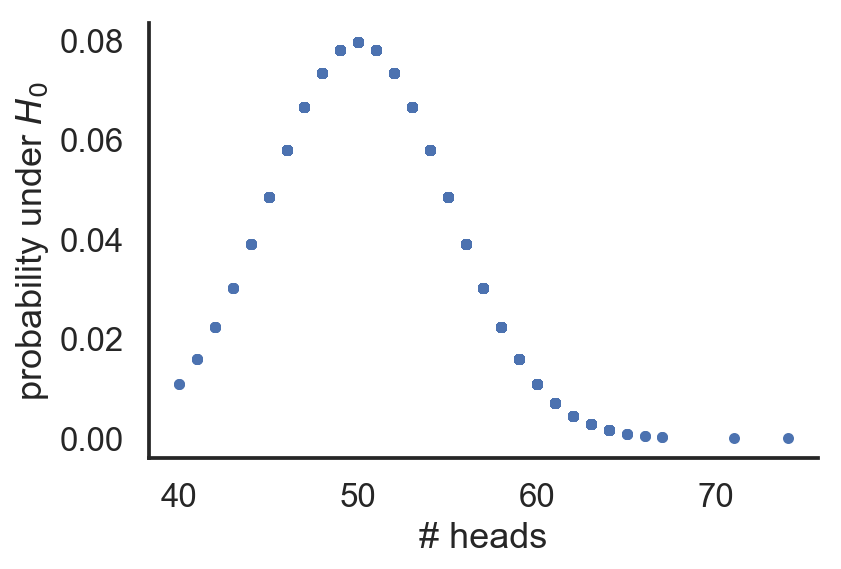

In [8]:
plt.plot(xs, H0.pmf(xs), '.')
plt.xlabel('# heads')
plt.ylabel('probability under $H_0$')
sns.despine()

A nice trick to solve this zero-from-non-zeros is to use the log-pmf and calculate the sum of log-likelihoods, which equals the log of product of likelihoods:
$$
\log\big(\prod_i{P(x_i)}\big) = \sum_i{\log\big(P(x_i)\big)}
$$

So the log-likelihood of H0 given all these data is:

In [9]:
H0.logpmf(xs).sum()

-3348.8472409781198

Can we find an hypothesis with stronger support from the evidence? That is, higher likelihood?

We calculate the likelihood for different $q$ values and plot them to find the most likely $q$.

In [10]:
def loglik(xs, q):
    H0 = scipy.stats.binom(n, q)
    return H0.logpmf(xs).sum()

qs = np.linspace(0, 1, 100)
logliks = np.array([loglik(xs, q) for q in qs])

most likely q=0.5354 (green)
real q=0.5400 (red)
null q=0.5000 (black)


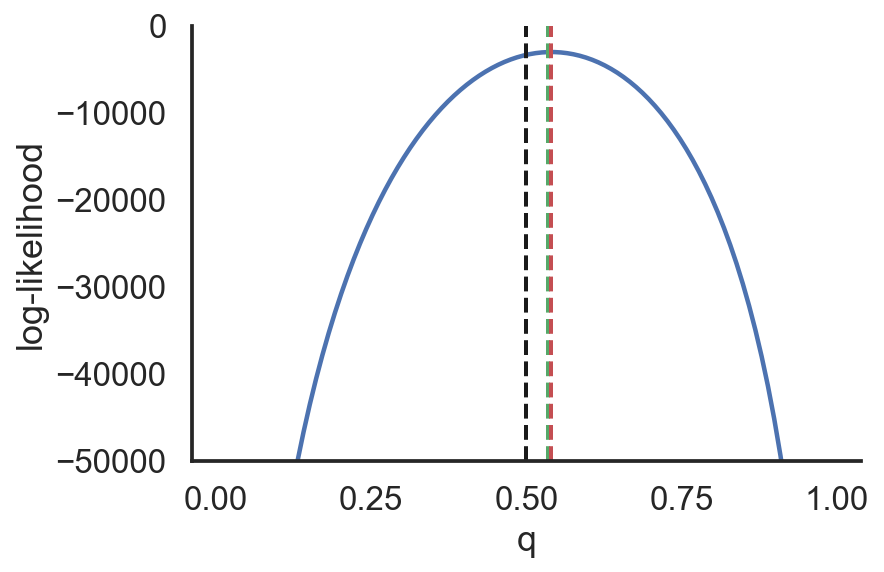

In [18]:
plt.plot(qs, logliks)
argmax = logliks.argmax()
plt.axvline(qs[argmax], ls='--', lw=2, color='g')
plt.axvline(q0, ls='--', lw=2, color='k')
plt.axvline(q, ls='--', lw=2, color='r')
plt.ylim(0, 1)
plt.ylim(-50000, 0)
plt.xlabel('q')
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.ylabel('log-likelihood')
sns.despine()

print('most likely q={:.4f} (green)'.format(qs[argmax]))
print('real q={:.4f} (red)'.format(q))
print('null q={:.4f} (black)'.format(q0))

This is the method of **maximum likelihood** and it works well: the most likely $q$ (green) is very close to the real $q$ (red).

## Using tests in scipy.stats

Instead of calculating likelihoods on our own, we can use an exact [binomial test](https://en.wikipedia.org/wiki/Binomial_test), which works for smaller `n` (sample size) and doesn't assume normality of the data. It basically does that same job, calculating the likelihood of seeing the data given the null hypothesis.

In [19]:
pval = scipy.stats.binom_test(x, n=n, p=q0)
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(pval, pval < 0.05))

P-value: 0.035, Reject null hypothesis: True


In [20]:
pval = scipy.stats.binom_test(x, n=n, p=qs[argmax])
print("P-value: {0:.2g}, Reject MLE hypothesis: {1}".format(pval, pval < 0.05))

P-value: 0.16, Reject MLE hypothesis: False


In [21]:
pval = scipy.stats.binom_test(x, n=n, p=q)
print("P-value: {0:.2g}, Reject true hypothesis: {1}".format(pval, pval < 0.05))

P-value: 0.19, Reject true hypothesis: False


## Exercise

Consider `x`, an array of 50 experimental measurements.
We would like to use a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to test the null hypothesis that the expected/real value of the measurement is 75. 

Use the function `scipy.stats.ttest` to calculate a P-value and make an hypothesis test (with a significance level of 0.05).

NormaltestResult(statistic=1.126778258696914, pvalue=0.5692764392536629)

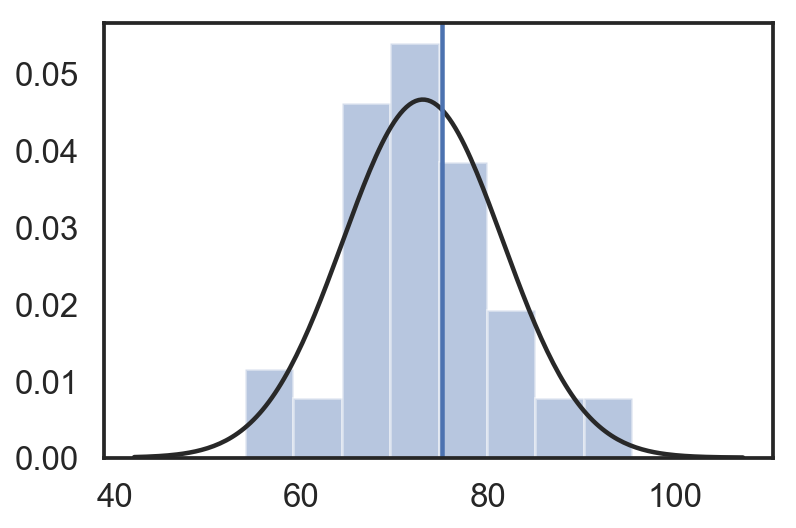

In [17]:
x = np.array([ 65.53023244,  72.23747986,  73.01265677,  89.9351998 ,
        70.6963815 ,  78.02590763,  81.2881422 ,  61.80569525,
        65.93705786,  70.54059758,  77.49758326,  68.42851182,
        68.55585283,  80.1871511 ,  74.65777598,  65.20851364,
        68.50039697,  65.90256468,  73.32305696,  74.03947153,
        77.1472388 ,  72.02604829,  82.7751142 ,  59.6132927 ,
        55.048079  ,  70.01523156,  90.5524559 ,  73.56715484,
        65.19466857,  76.66137409,  71.11086989,  58.7251773 ,
        53.9227519 ,  78.80348065,  65.70707516,  71.64598738,
        78.4655557 ,  68.55593575,  95.4389177 ,  65.28104808,
        79.67603416,  73.25855752,  67.59741922,  88.1492883 ,
        83.2779776 ,  80.9657968 ,  72.18488899,  76.23291307,
        76.50505861,  76.31360889])
sns.distplot(x, kde=False, fit=scipy.stats.norm)
plt.axvline(75)
scipy.stats.normaltest(x)

# Correlation

Next, we will use some tennis data to show how to calculate correlations and their statistical significance.

Start by downloading the data from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.

If you get an SSL error, you should probably update the certifi package (`conda update certifi`).

In [23]:
filename = '../data/tennis.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve(
        'http://github.com/ipython-books/cookbook-data/raw/master/tennis.zip', filename)
print("Data file exists:", os.path.exists(filename))

zf = zipfile.ZipFile(filename)
for f in zf.filelist: 
    print(f.filename)

Data file exists: True
data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


We have data for four prolific tennis player. We'll go with Novak Djokovic.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Novak_Djokovic_2007_US_Open.jpg/320px-Novak_Djokovic_2007_US_Open.jpg)

In [24]:
player = 'Novak Djokovic'
with zf.open('data/{}.csv'.format(player.replace(' ', '-'))) as f:
    df = pd.read_csv(f)
df.head()

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,...,player2 2nd serve return points total,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total
0,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,Q,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,"Serbia F5, Beograd",21.07.2003,FU,Outdoor: Clay,Draw: 32,NaN,774.0,$118,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df.columns

Index(['year', 'tournament', 'start date', 'type', 'surface', 'draw',
       'atp points', 'atp ranking', 'tournament prize money', 'round',
       'opponent', 'ranking', 'score', 'stats link', 'tournament.1',
       'tournament round', 'time', 'winner', 'player1 name',
       'player1 nationality', 'player1 aces', 'player1 double faults',
       'player1 1st serves in', 'player1 1st serves total',
       'player1 1st serve points won', 'player1 1st serve points total',
       'player1 2nd serve points won', 'player1 2nd serve points total',
       'player1 break points won', 'player1 break points total',
       'player1 service games played', 'player1 1st serve return points won',
       'player1 1st serve return points total',
       'player1 2nd serve return points won',
       'player1 2nd serve return points total',
       'player1 break points converted won',
       'player1 break points converted total', 'player1 return games played',
       'player1 total service points won',
 

We'll start by plotting the **% of points won** by Novak vs the **% of points he aced**.

We'll use different markers for wins and losses.

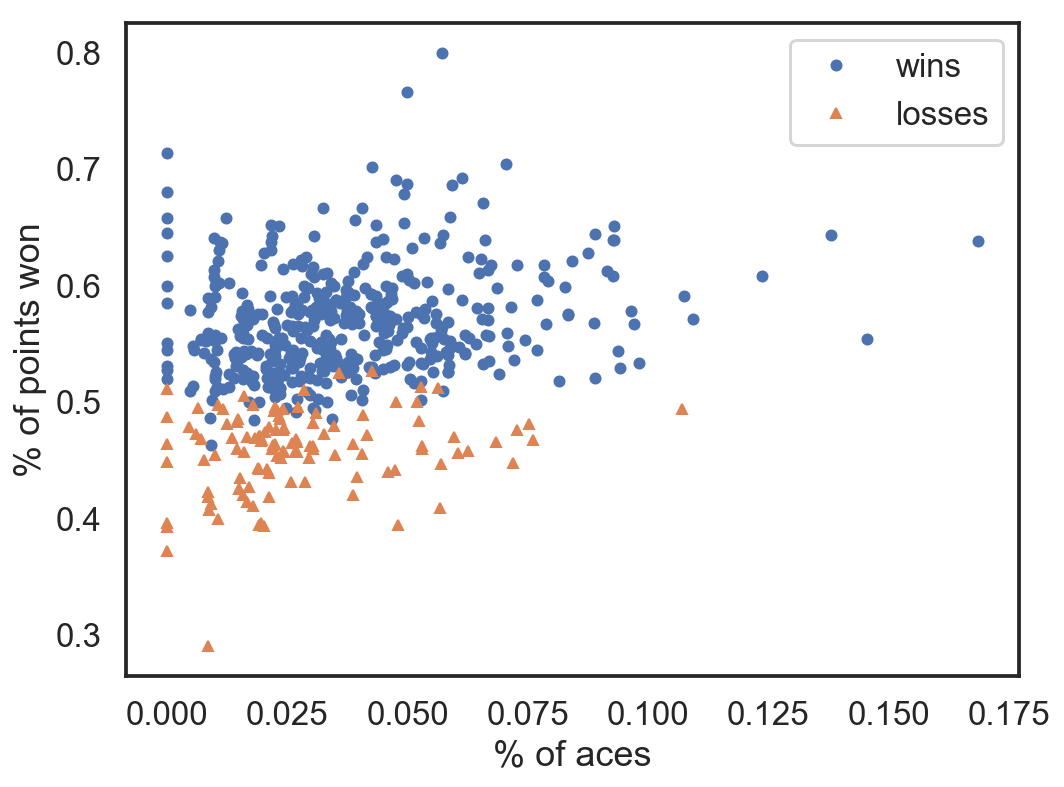

In [26]:
npoints = df['player1 total points total']
points = df['player1 total points won'] / npoints
aces = df['player1 aces'] / npoints

player1_won = df['winner'] == player

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(aces[player1_won], points[player1_won], 'o', markersize=5,  label='wins')
plt.plot(aces[~player1_won], points[~player1_won], '^', markersize=5, label='losses')
plt.xlabel('% of aces')
plt.ylabel('% of points won')
plt.legend();

Obviously % of points won is a strong indicator of winning; % of aces seems also to be an indicator, but not as strong, and there seems to be some correlation between aces and points won.

Let's calculate the correlation between % points won and % of aces. We use [*Pearson's linear correlation*](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient). 

First, we create a new data frame just with the relevant data:

In [27]:
df_cor = pd.DataFrame(
    {
        'points': points, 
        'aces': aces
    }
).dropna()
df_cor.tail()

,points,aces
725,0.686441,0.059322
726,0.557522,0.066372
727,0.555556,0.015873
728,0.533333,0.031884
729,0.523035,0.024390


Then we calculate the (symmetric) correlation matrix:

In [28]:
df_cor.corr() # default method is "pearson"

,points,aces
points,1.000000,0.280572
aces,0.280572,1.000000


A correlation coefficient of 0.28 is suggestive of a positive correlation. 

We want to estimate the statistical significance of the correlation between the variables.
For this purpose we use a *chi-squared test* of the independence of variables in a contingency table.

First, we binarize our variables. Here, the value corresponding to the number of aces is `True` if the player is serving more aces than usual in a match, and `False` otherwise. Similarly, we define the `result` as `True` if the % of points is larger than usual and `False` otherwise.

We then create a contingency table:

In [29]:
df_cor['result'] = df_cor['points'] > df_cor['points'].median()
df_cor['manyaces'] = df_cor['aces'] > df_cor['aces'].median()

contingency_table = pd.crosstab(df_cor['result'], df_cor['manyaces'])
contingency_table

manyaces,False,True
result,,
False,178,105
True,105,177


We can see that the main diagonal (`False-False` and `True-True`) is heavier then the cross diagonal.
To quantify this, we use the `ch2_contingency` function to calculate the P-value - the probability to get this table given the null hypothesis that above aces and points are independent:

In [30]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(contingency_table)
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(p, p < 0.05))

P-value: 1.8e-09, Reject null hypothesis: True


## Exercise

It is commonly said that [Rafael Nadal](https://en.wikipedia.org/wiki/Rafael_Nadal) is a dominant clay player.

![Rafa on clay](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/Nadal_2010_Madrid_01.jpg/330px-Nadal_2010_Madrid_01.jpg)

Let's examine if indeed there is a correlation between the surface Rafa plays on and his winning.

The following cell loads the data for Rafa, discards surfaces on which he played less than 100 matches, and plots a bar plots of the results

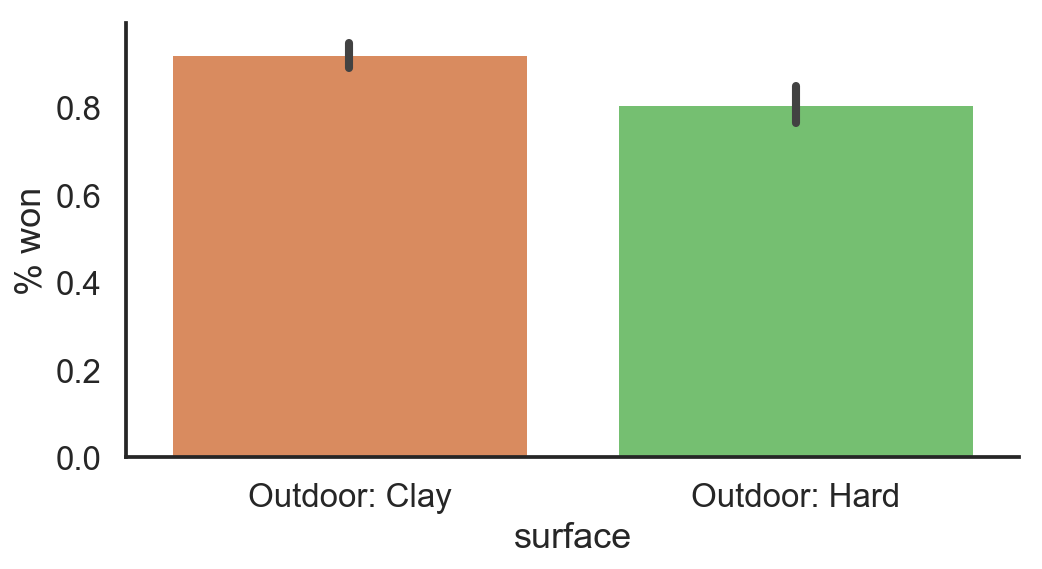

In [55]:
player = 'Rafael Nadal'
with zf.open('data/{}.csv'.format(player.replace(' ', '-'))) as f:
    df = pd.read_csv(f)

surface_count = df['surface'].value_counts()
surfaces = surface_count[surface_count > 100].index
df = df[df['surface'].isin(surfaces)]
df['win'] = df.winner == player

fig = plt.figure(figsize=(8, 4))
_, green, red = sns.color_palette('muted', 3)
sns.set_palette([green, red])
sns.barplot('surface', 'win', data=df)
plt.ylabel('% won')
sns.despine()

Indeed it seems that the probability of winning is higher on clay for Rafa. 

**Use a contingency table** to perform a chi-sqaure test to test the null hypothesis that winning is independent of surface for Rafa.

In [16]:
# Your code here

surface,Outdoor: Clay,Outdoor: Hard
win,,
False,28,64
True,329,268


In [17]:
# Your code here
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(p, p < 0.05))

P-value: 1.7e-05, Reject null hypothesis: True


# Estimating distributions

SciPy has builtin functions to estimate probability distributions from data using [*Maximum Likelihood Estimators*](http://en.wikipedia.org/wiki/Maximum_likelihood) (MLE).

Let's load some transplant survival data (originally from *Miller, R. (1976). Least squares regression with censored dara. Biometrica, 63 (3). 449-464*). This data contains the survival time after receiving a heart transplant.

In [31]:
df = pd.read_csv('../data/heart.csv')
df.head()

,survival
0,15.0
1,3.0
2,624.0
3,46.0
4,127.0


We start by plotting the survival data for each patient, by descending survival, and the histogram of the survival data.

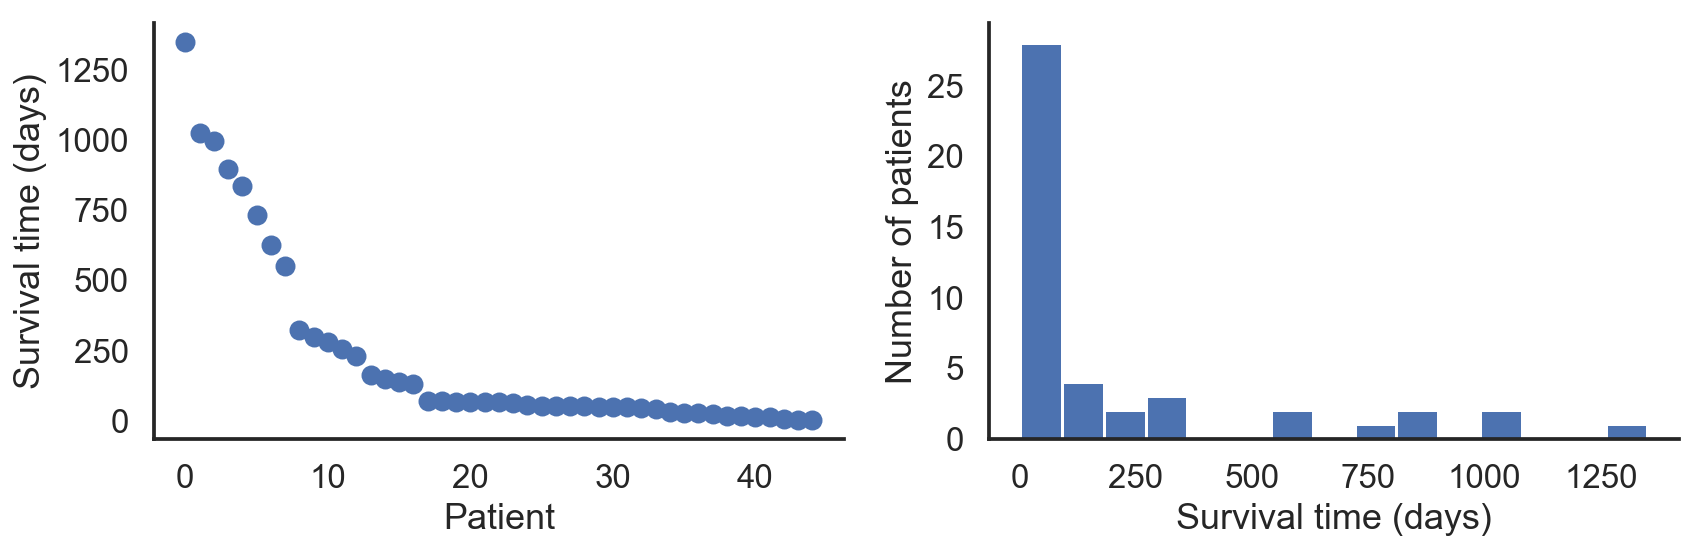

In [32]:
survival = df.survival

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(sorted(survival)[::-1], 'o')
ax[0].set(xlabel='Patient', ylabel='Survival time (days)')

ax[1].hist(survival, bins=15)
ax[1].set(xlabel='Survival time (days)', ylabel='Number of patients')

fig.tight_layout()
sns.despine()

It seems that the histogram is decreasing rapidly (this is data from the 1970s), so we will try to fit an exponential distribution to the data.

We do this using the `scipy.stats.expon` class which has a `fit` class method (as do all the continous distribution classes).
This function finds the most likely parameters for the distribution and returns the distribution paramters (the location and scale, in this case).

In [33]:
params = scipy.stats.expon.fit(survival)
print(params)

(1.0, 222.2888888888889)


If we want to plot the histogram with a fitted distribution, we can just use Seaborn:

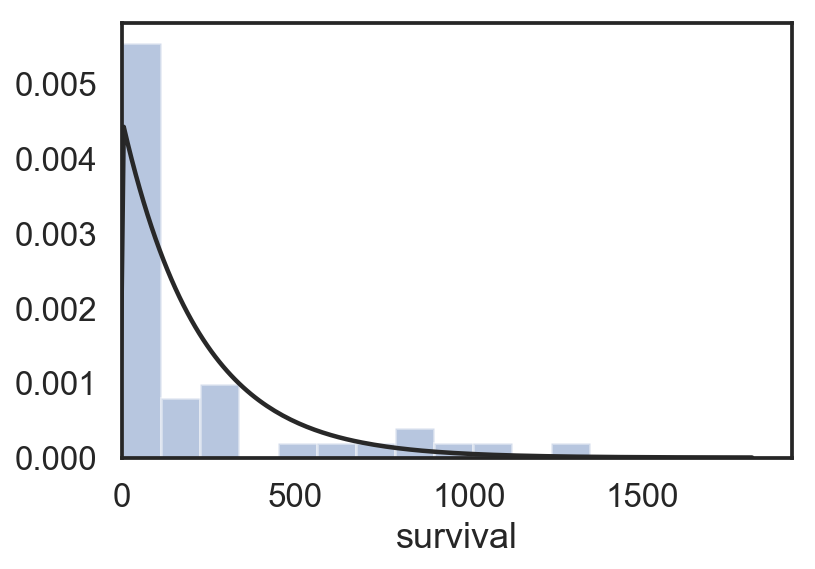

In [34]:
sns.distplot(survival, kde=False, fit=scipy.stats.expon)
plt.xlim(0, None);

This doesn't look that good. A statistical test for the fit of the distribution to the data (a statistical quantification to the statement "this doesn't look that good") can be done with the [Kolmogorov-Smirnov goodness of fit test](http://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test) implemented in the `scipy.stats.kstest` function. The null hypothesis in this case is that the data came from the estimated exponential distribution.

In [35]:
fitted_expon = scipy.stats.expon(*params)
D, p = scipy.stats.kstest(survival, fitted_expon.cdf)
print("Exponential distribution")
print("P-value: {0:.2g}, reject null hypothesis: {1}".format(p, p < 0.05))

Exponential distribution
P-value: 8.6e-06, reject null hypothesis: True


Indeed, we reject the null hypothesis - the exponential distribution is unlikely for this dataset.

## Exercise

Let's try a different distribution, the [fatigue life distribution](https://en.wikipedia.org/wiki/Birnbaum%E2%80%93Saunders_distribution), used extensively in reliability applications to model failure times.

Fit the distribution to the data, test it with the `kstest`, and plot it with the data and the exponential distribution for comparison.

**Note** the fatigue-life distribution has three parameters whereas the exponential distribution has two, so we should probably use another statistical method to decide on the correct model, such as [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)

# Kernel density estimation

Sometimes we don't have an idea as to what is the *real* distribution of the data.
In these cases we can perform non-parameteric estimation to fit an arbitrary family of function to the data distribution. 

Here, we use a [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE).
For example, Seaborn will automatically use KDE with a gaussian kernel if we use `distplot`:

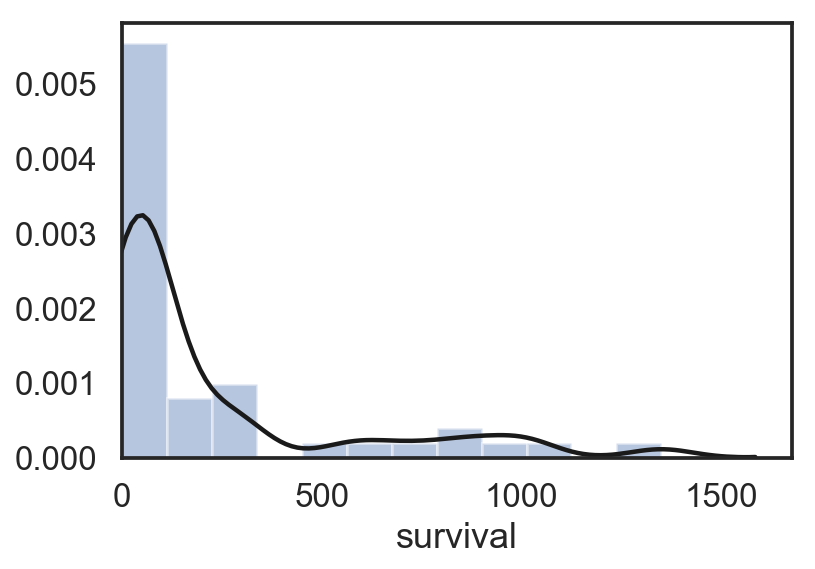

In [36]:
sns.distplot(survival, kde_kws=dict(color='k'))
plt.xlim(0, None);

How is this done?

For a histogram, 
- the horizontal axis is divided into bins that cover the range of the data.
- (here, we have 6 bins each of width 2, from -4 to 8.)
- when a value falls inside a bin, we place a box of height `1/(bins*width)` (here 1/12~0.83).
- if more than one value falls inside the same bin, we stack the boxes on top of each other.

In [37]:
x = np.array([-2.1, -1.3, -0.4, 1.9, 5.1, 6.2])
n = x.size

bins = range(-4, 10, 2)

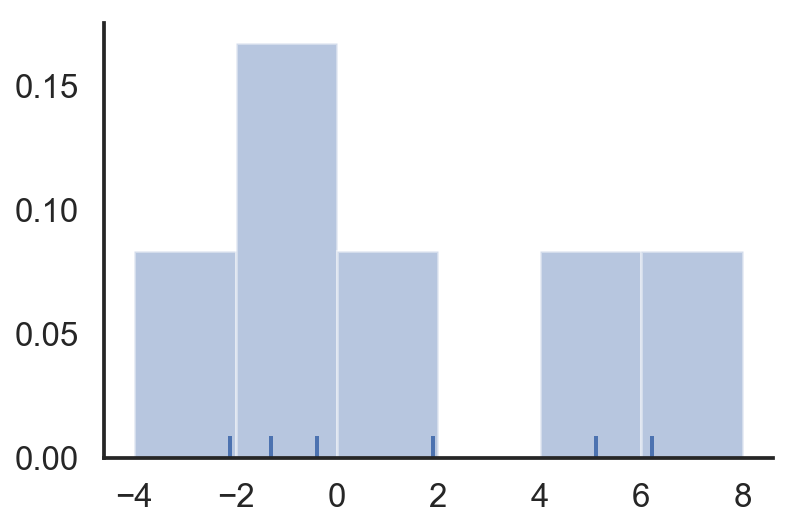

In [38]:
sns.distplot(x, bins, kde=False, rug=True, rug_kws=dict(lw=2), norm_hist=True)
plt.xticks(bins)
plt.xlim(-4.6, 8.6)
sns.despine()

For the kernel density estimate, 
- we place a (normal) kernel with variance $\sigma^2$ (red lines) on each of the values `x[i]`.
- the kernels are summed to make the kernel density estimate (black line).

The $\sigma$ parameter is related to the bandwith parameter `h`, which is a free parameter.

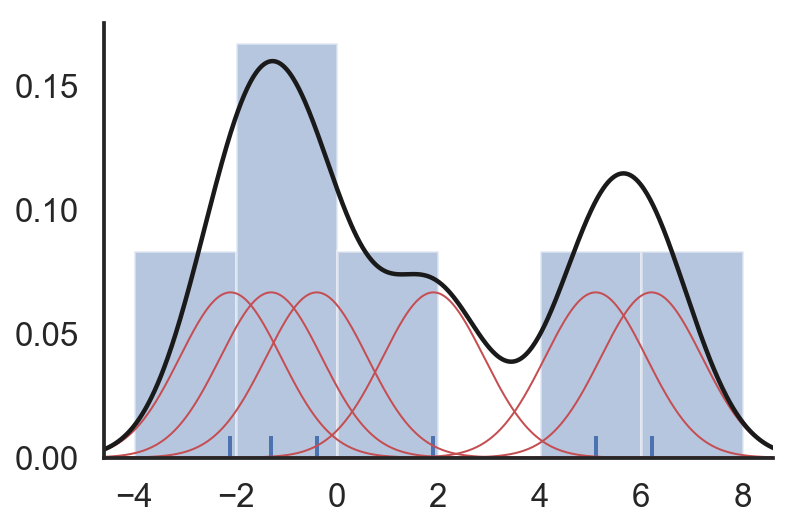

In [39]:
# same histogram as above
sns.distplot(x, bins, kde=False, rug=True, rug_kws=dict(lw=2), norm_hist=True) 

σ = 1
xrange = np.linspace(-8, 12, 1000)

total_kde = np.zeros(xrange.size) # sum all kernels here
for x_i in x:
    norm = scipy.stats.norm(x_i, σ)
    kde_i = norm.pdf(xrange)/n # normal (gaussian) kernel
    total_kde += kde_i
    plt.plot(xrange, kde_i, color='r', lw=1) # plot each kernel
plt.plot(xrange, total_kde, color='k') # plot kernel sums

plt.xticks(bins)
plt.xlim(-4.6, 8.6)
sns.despine()

Now that we know how it works we can just use Seaborn:

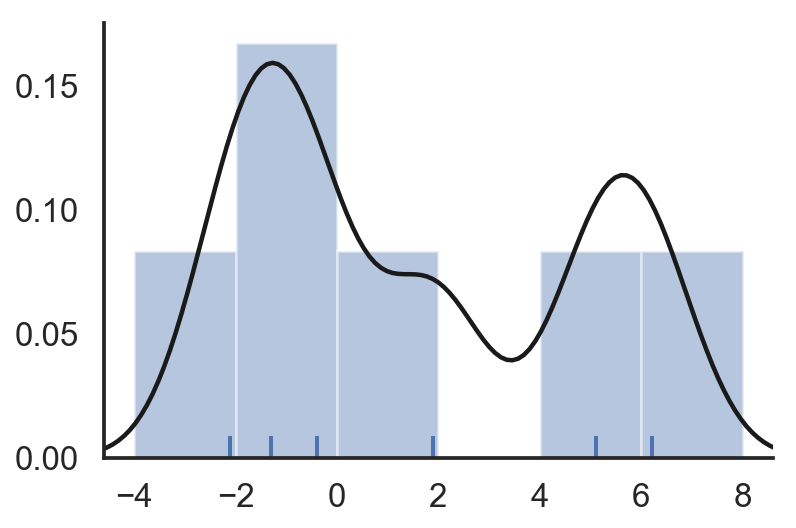

In [40]:
sns.distplot(x, bins, kde=True, rug=True, rug_kws=dict(lw=2), norm_hist=True, 
             kde_kws=dict(bw=σ, color='k'))
plt.xticks(bins)
plt.xlim(-4.6, 8.6)
sns.despine()

# 2D kernel density estimation

We'll now use KDE to estimate the density of a spatial empirical distribution.
We look at the geographical locations of tropical [cyclones](https://en.wikipedia.org/wiki/Cyclone) (sometimes known as hurricanes, typhoons, or tornados) from 1848 to 2013, based on data provided by the NOAA, the US' National Oceanic and Atmospheric Administration.

We'll need the [CatroPy](http://scitools.org.uk/cartopy/) package, which is a *Matplotlib* add-on that displays maps.

In [42]:
import cartopy.crs as ccrs

We load the storms data set from the [IPython Cookbook data repo](https://github.com/ipython-books/cookbook-data).

In [49]:
url = 'https://github.com/ipython-books/cookbook-data/raw/master/storms.zip'
filename = '../data/storms.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
print("Data file exists:", os.path.exists(filename))

zf = zipfile.ZipFile(filename)
with zf.open('data/Allstorms.ibtracs_wmo.v03r05.csv') as f:
    df = pd.read_csv(f)
df.head()

Data file exists: True


,Serial_Num,Season,Num,Basin,Sub_basin,Name,ISO_time,Nature,Latitude,Longitude,Wind(WMO),Pres(WMO),Center,Wind(WMO) Percentile,Pres(WMO) Percentile,Track_type
0,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-11 06:00:00,NR,-8.6,79.8,0.0,0.0,reunion,-100.0,-100.0,main
1,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-12 06:00:00,NR,-9.0,78.9,0.0,0.0,reunion,-100.0,-100.0,main
2,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-13 06:00:00,NR,-10.4,73.2,0.0,0.0,reunion,-100.0,-100.0,main
3,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-14 06:00:00,NR,-12.8,69.9,0.0,0.0,reunion,-100.0,-100.0,main
4,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-15 06:00:00,NR,-13.9,68.9,0.0,0.0,reunion,-100.0,-100.0,main


The interesting columns for us are:

In [50]:
df = df[['Serial_Num', 'Season', 'Basin', 'Latitude', 'Longitude']]
df.head()

,Serial_Num,Season,Basin,Latitude,Longitude
0,1848011S09080,1848,SI,-8.6,79.8
1,1848011S09080,1848,SI,-9.0,78.9
2,1848011S09080,1848,SI,-10.4,73.2
3,1848011S09080,1848,SI,-12.8,69.9
4,1848011S09080,1848,SI,-13.9,68.9


The dataset contains information about most storms since 1848. A single storm may appear multiple times across several consecutive days. We group the data by `Serial_num` (storm identifier) and aggregate to get the average location of every storm:

In [51]:
dfs = df.groupby('Serial_Num')
pos = dfs[['Latitude', 'Longitude']].mean()
pos.head()

,Latitude,Longitude
Serial_Num,,
1848011S09080,-15.918182,71.854545
1848011S15057,-24.116667,52.016667
1848061S12075,-20.528571,65.342857
1851080S15063,-17.325000,55.400000
1851080S21060,-23.633333,60.200000


We plot a world map with an equi-rectangular projection called Plate Carree ([let's not get started on map projection, ok?](https://www.youtube.com/watch?v=QMlp8BeBJgg))

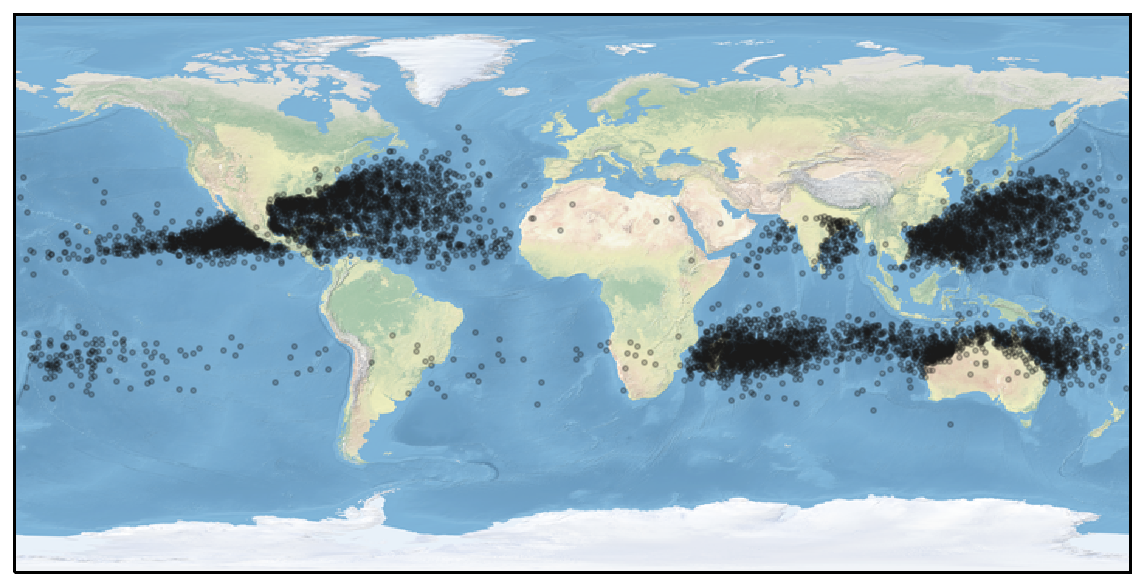

In [52]:
# create the projections and the axes
crs = ccrs.PlateCarree()
ax = plt.axes(projection=crs)
# plot the map
ax.stock_img()
# get the positions and plot the markers
x = pos.Longitude.values
y = pos.Latitude.values
ax.plot(x, y, '.k', markersize=5, alpha=0.25)

# resize image
ax.figure.set_figwidth(10)
ax.figure.set_figheight(6)

Indeed we see that the storms mostly occur around the tropics, mostly the coasts of central america, madagascar, northrn austrialia, southeast asia, and Japan.

To estimate the storm distribution, we first need to transform the storms positions from geodetic coordinates (longtitude and latitude) to the map's coordinates (plate carree).

In [53]:
geo = ccrs.Geodetic()
h = geo.transform_points(crs, x, y)[:, :2].T
h.shape

(2, 6940)

Now we perform the density estimation using `scipy.stats.gaussian_kde`, which returns a Python function which estimates the density function.

In [54]:
kde = scipy.stats.gaussian_kde(h)

We'll now apply this `kde` function to a 2D grid of points on the map.
We do this with `meshgrid`.

We set the north-south resolution to be `k` and the east-west to be `2k`, and get the corners of the grid from the map axes.

In [55]:
k = 100
x0, x1, y0, y1 = ax.get_extent()
xrange = np.linspace(x0, x1, 2 * k)
yrange = np.linspace(y0, y1, k)

`meshgrid` returns a list of two `(k, 2k)` arrays, the first for the x coordinates of each point in the grid, and the second for the y coordinates of each point in the grid.

In [56]:
tx, ty = np.meshgrid(xrange, yrange)
tx.shape, ty.shape

((100, 200), (100, 200))

We reshape the grid for the `kde` function, which expects one or many points.

In [57]:
mesh = np.vstack((tx.ravel(), ty.ravel()))
mesh.shape, 2*k**2

((2, 20000), 20000)

We evaluate the `kde` function on the grid points, and reshape the result back to `(2, 2k)`.

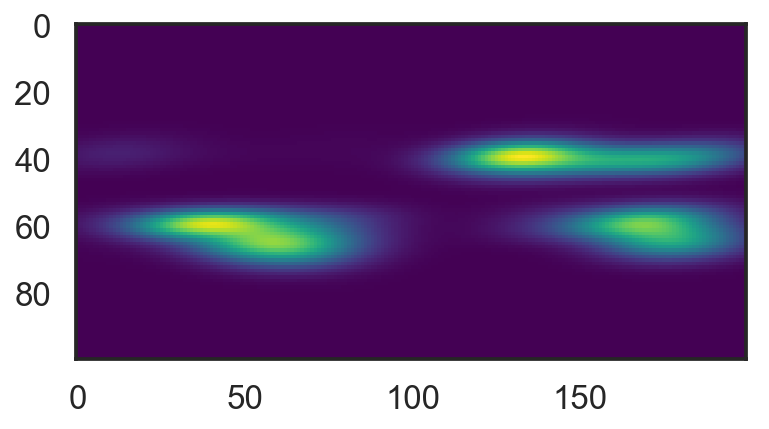

In [58]:
v = kde(mesh).reshape((k, 2 * k))
plt.imshow(v, cmap='viridis');

Before displaying the KDE heatmap on the map, we need to use a special colormap with a transparent channel.
This will allow us to superimpose the heatmap on the stock map image.

In [59]:
# https://stackoverflow.com/a/37334212/1595060
cmap = plt.get_cmap('Reds')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)
my_cmap = mpl.colors.ListedColormap(my_cmap);

Finally, we plot the density map on (or rather above) the geographical map.

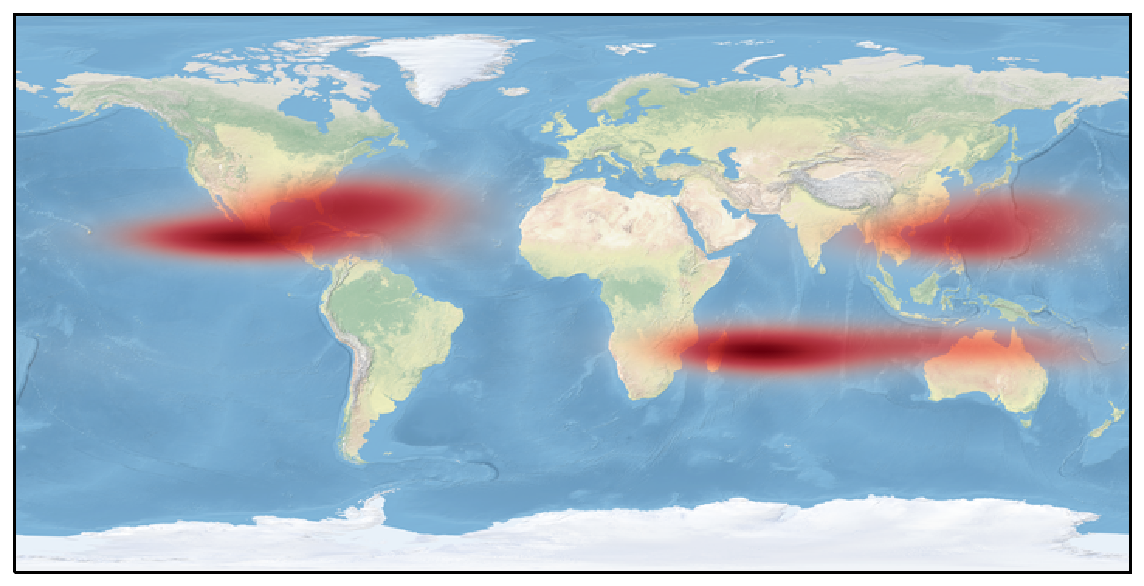

In [60]:
ax = plt.axes(projection=crs)
ax.stock_img()
ax.imshow(v, origin='lower',
         extent=[x0, x1, y0, y1],
         interpolation='bilinear',
         cmap=my_cmap)
ax.figure.set_figwidth(10)
ax.figure.set_figheight(6)

## Exercise

Consider the following random data, drawn from a 2D normal distribution:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


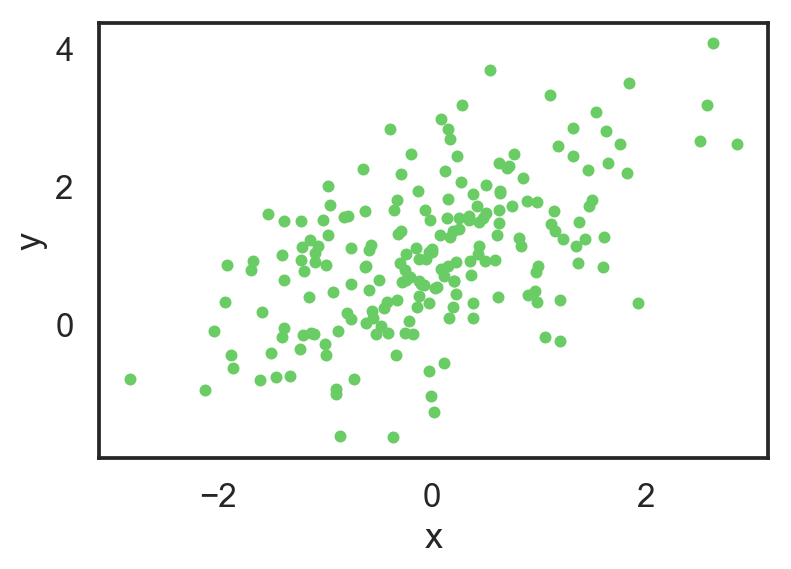

In [65]:
mean, cov = [0, 1], [(1, .5), (.5, 1)]
data = np.random.multivariate_normal(mean, cov, 200)
df = pd.DataFrame(data, columns=["x", "y"])

df.plot.scatter('x', 'y');

Use a KDE approach to estimate and plot the distribution of the random data. 
**Note** if you only want to plot, rather than actually estimate the `kde` function, you can use Seaborn's [`kdeplot`](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html) function. Experiment with the `shade`, `cmap`, and `n_levels` keywords to get aestheticly pleasing results.

# References

- [IPython Cookbook](http://ipython-books.github.io/cookbook/): IPython Interactive Computing and Visualization Cookbook by Cyrille Rossant.
- [scipy.stats tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
- [Scipy's statistical functions](http://docs.scipy.org/doc/scipy/reference/stats.html)
- [Visualizing distributions in Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html)
- [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) on Wikipedia

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)